<a href="https://colab.research.google.com/github/gpadmaperuma/DATA620-GroupHomework/blob/main/DATA_620_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Name Gender Classifier
**by Don Padmaperuma & Grace Han**

## Assignment

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. 

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. 

Then, starting with the example name gender classifier, make incremental improvements. 

Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. 

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?



In [1]:
import collections
import nltk
nltk.download('names')
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.metrics import ConfusionMatrix, accuracy, precision, recall, f_measure
import random

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [1]:
import math

In [2]:
len(names.words('female.txt')), len(names.words('male.txt'))

(5001, 2943)

We can see from above numbers that there are more female names (almost twise as male names) compared to the male names in the dataset. 

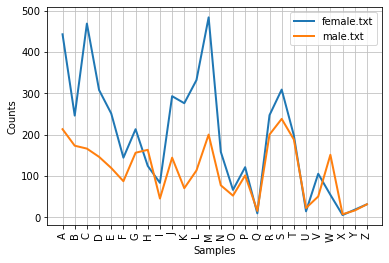

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [3]:
# Check distribution of the first letter of the name.
gender_freq = nltk.ConditionalFreqDist((fileid, name[0])
  for fileid in names.fileids()
  for name in names.words(fileid))
gender_freq.plot()

Above graph shows the comparison of distribution of beginning letter of the names by gender. We can see that more female names starts with letter A, C, M and S. 

In [4]:
# combine male and female names and shuffle them.
names = ([(name, 'male') for name in names.words('male.txt')] + \
        [(name, 'female') for name in names.words('female.txt')])
random.shuffle(names)

In [5]:
# Take a look at the combined data
names[1:5]

[('Blaire', 'female'),
 ('Johannes', 'male'),
 ('Kelsey', 'female'),
 ('Querida', 'female')]

In [6]:
# unique names
len(set(item[0] for item in names))

7579

We removed the names that was listed as both males and females and was listed twice.

In [7]:
# names that are not unique
names_only = [item[0] for item in names]
names_dist = nltk.FreqDist(names_only)
names_duplicates = [(k,v) for k,v in names_dist.items() if v>1 ] 
names_duplicates

[('Kelsey', 2),
 ('Jere', 2),
 ('Geri', 2),
 ('Barrie', 2),
 ('Ikey', 2),
 ('Meryl', 2),
 ('Lanny', 2),
 ('Quentin', 2),
 ('Nicky', 2),
 ('Andie', 2),
 ('Merrill', 2),
 ('Sandy', 2),
 ('Daffy', 2),
 ('Tammie', 2),
 ('Kelley', 2),
 ('Terry', 2),
 ('Dannie', 2),
 ('Corrie', 2),
 ('Leigh', 2),
 ('Wallie', 2),
 ('Gabriell', 2),
 ('Sibyl', 2),
 ('Cass', 2),
 ('Scotty', 2),
 ('Hillary', 2),
 ('Martie', 2),
 ('Laurie', 2),
 ('Drew', 2),
 ('Lesley', 2),
 ('Ira', 2),
 ('Dell', 2),
 ('Willi', 2),
 ('Gill', 2),
 ('Alex', 2),
 ('Tracy', 2),
 ('Patrice', 2),
 ('Adrian', 2),
 ('Torey', 2),
 ('Sonnie', 2),
 ('Freddy', 2),
 ('Bryn', 2),
 ('Lindsey', 2),
 ('Virgie', 2),
 ('Ajay', 2),
 ('Glenn', 2),
 ('Clare', 2),
 ('Sunny', 2),
 ('Blake', 2),
 ('Benny', 2),
 ('Devin', 2),
 ('Brook', 2),
 ('Lane', 2),
 ('Jordan', 2),
 ('Caryl', 2),
 ('Jermaine', 2),
 ('Henrie', 2),
 ('Austin', 2),
 ('Andrea', 2),
 ('Jessie', 2),
 ('Brandy', 2),
 ('Darby', 2),
 ('Carroll', 2),
 ('Casey', 2),
 ('Shell', 2),
 ('Fred', 2),


In [8]:
# FROM Shovan
# Remove the duplicates and show total number of unique names
names2remove = [item[0] for item in names_duplicates]
final_names = [item for item in names if not item[0] in names2remove]
len(final_names)

7214

In [9]:
names = final_names
len(names)

7214

## Split into Train, DevTest and Test Data

In [10]:
## from SilverN
train_set = names[1000:]        # Training set
test_set = names[:500]   # Test
devtest_set = names[500:1000]   #development test

In [11]:
## from Showvan

# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_set)))
print("Dev-Test Set = {}".format(len(devtest_set)))
print("Test Set = {}".format(len(test_set)))

Training Set = 6214
Dev-Test Set = 500
Test Set = 500


In [ ]:
## GH: this section should be placed before the 1st feature
## THis is the right location
## from Shovan
# Write a function for manually calculate the recall error and precision formance, for comparison purpose 
#(to compare the automatically generated performance indicator)

def performance_metrics(model, train, digits=4):
    """Prints the precision and recall of an NLTK Naive Bayes model."""
    reference = collections.defaultdict(set)
    test = collections.defaultdict(set)
    
    for i, (features, label) in enumerate(train):
        reference[label].add(i)
        pred = model.classify(features)
        test[pred].add(i)
        
    m_precision = round(precision(reference['male'], test['male']), digits)
    f_precision = round(precision(reference['female'], test['female']), digits)
    
    m_recall = round(recall(reference['male'], test['male']), digits)
    f_recall = round( recall(reference['female'], test['female']), digits)
        
    print('Male precision: ', m_precision)
    print('Female precision: ', f_precision)
    print('Male recall: ', m_recall)
    print('Female recall: ', f_recall)

# Features - First Feature

The first feature contains the first letter, last letter, prefix and suffix, as well as the vowels (aeiou, we did not include the y in here which is optional)

In [13]:
## from SilverN

def gender_features1(name):
    features = {}
    features["firstletter"] = name[0].lower()
    features["lastletter"] = name[-1].lower()
    features["suffix2"]= name[-2:].lower()
    features["preffix2"]= name[:2].lower()
    
    for letter in 'aeiou':   ## vowels
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features

In [14]:
featuresets = [(gender_features1(n), g) for (n,g) in names]
featuresets[0]

({'firstletter': 'd',
  'lastletter': 'l',
  'suffix2': 'll',
  'preffix2': 'da',
  'count(a)': 1,
  'has(a)': True,
  'count(e)': 1,
  'has(e)': True,
  'count(i)': 0,
  'has(i)': False,
  'count(o)': 0,
  'has(o)': False,
  'count(u)': 0,
  'has(u)': False},
 'female')

### Split Data Based on 1st Feature 

In [15]:
### Split data
train_set_fe = featuresets[1000:]
test_set_fe =featuresets[:500]
devtest_set_fe =featuresets[500:1000]

In [16]:
## GH: this section should be placed before the 1st feature
## NOT TO RUN HERE
## from Shovan
# Write a function for manually calculate the recall error and precision formance
def performance_metrics(model, train, digits=4):
    """Prints the precision and recall of an NLTK Naive Bayes model."""
    reference = collections.defaultdict(set)
    test = collections.defaultdict(set)
    
    for i, (features, label) in enumerate(train):
        reference[label].add(i)
        pred = model.classify(features)
        test[pred].add(i)
        
    m_precision = round(precision(reference['male'], test['male']), digits)
    f_precision = round(precision(reference['female'], test['female']), digits)
    
    m_recall = round(recall(reference['male'], test['male']), digits)
    f_recall = round( recall(reference['female'], test['female']), digits)
        
    print('Male precision: ', m_precision)
    print('Female precision: ', f_precision)
    print('Male recall: ', m_recall)
    print('Female recall: ', f_recall)

## Classifier - NaiveBayes -on 1st Feature


In [17]:
classifier = nltk.NaiveBayesClassifier.train(train_set_fe)
print(classifier.classify(gender_features1('Stefani'))) 
print(classifier.classify(gender_features1('Steffan'))) 

female
male


In [18]:
# Show Accuracy
print("train_set: ", nltk.classify.accuracy(classifier, train_set_fe))
print("test_set: ", nltk.classify.accuracy(classifier, test_set_fe))
print("devtest_set: ", nltk.classify.accuracy(classifier, devtest_set_fe))

train_set:  0.8408432571612487
test_set:  0.83
devtest_set:  0.856


In [19]:
# Show important features
classifier.show_most_informative_features(5)

Most Informative Features
              lastletter = 'k'              male : female =     67.7 : 1.0
                 suffix2 = 'la'           female : male   =     66.5 : 1.0
                 suffix2 = 'ta'           female : male   =     62.8 : 1.0
                 suffix2 = 'us'             male : female =     61.5 : 1.0
              lastletter = 'a'            female : male   =     54.4 : 1.0


In [20]:
# Check errors
## GH: May not be necessary
errors = []
for (name, tag) in devtest_set:
    guess = classifier.classify(gender_features1(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

In [22]:
## GH: Not to print these out
## works wo error
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
   print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=Berny                         
correct=female   guess=male     name=Bevvy                         
correct=female   guess=male     name=Bonny                         
correct=female   guess=male     name=Corabel                       
correct=female   guess=male     name=Cybill                        
correct=female   guess=male     name=Devan                         
correct=female   guess=male     name=Dorothy                       
correct=female   guess=male     name=Edyth                         
correct=female   guess=male     name=Eleonore                      
correct=female   guess=male     name=Estell                        
correct=female   guess=male     name=Franny                        
correct=female   guess=male     name=Gael                          
correct=female   guess=male     name=Gert                          
correct=female   guess=male     name=Guendolen                     
correct=female   guess=male     name=Helge      

In [23]:
print("Error count: ", len(errors))

Error count:  72


In [24]:
## GH modified --- from shovan

train_set = [(gender_features1(n), g) for (n,g) in train_set]
devtest_set = [(gender_features1(n), g) for (n,g) in devtest_set]
test_set = [(gender_features1(n), g) for (n,g) in test_set]

nb1 = nltk.NaiveBayesClassifier.train(train_set) 

print('Devset accuracy is')
print(nltk.classify.accuracy(nb1, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb1, test_set))

Devset accuracy is
0.856
Test accuracy is
0.83


In [25]:
## from shovan
performance_metrics(nb1, train_set)
performance_metrics(nb1, devtest_set)

Male precision:  0.7619
Female precision:  0.8886
Male recall:  0.8056
Female recall:  0.8604
Male precision:  0.8032
Female precision:  0.8878
Male recall:  0.8118
Female recall:  0.8822


## Classifier - DecisionTree-on 1st Feature

In [26]:
classifier_tree = nltk.DecisionTreeClassifier.train(train_set_fe)

print("train_set: ", nltk.classify.accuracy(classifier_tree, train_set_fe))
print("test_set: ", nltk.classify.accuracy(classifier_tree, test_set_fe))
print("devtest_set: ", nltk.classify.accuracy(classifier_tree, devtest_set_fe))

train_set:  0.9747344705503701
test_set:  0.808
devtest_set:  0.834


In [27]:
## gh: this section buggy now, but was not buggy in earlier run, why

errors2 = []
for (name, tag) in devtest_set:
    guess = classifier_tree.classify(gender_features1(name))
    if guess != tag:
        errors2.append( (tag, guess, name) )

KeyError: 0

In [28]:
## GH: Not to print these out
for (tag, guess, name) in sorted(errors2): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
   print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

In [29]:
print("Error count")
len(errors2)

Error count


0

## Features - 2nd Feature

In [30]:
# extract name’s characteristics
def gender_features2nd(name):
    name = name.lower()
    return{
        'first_letter': name[0],
        'first2_letter': name[0:2],
        'first3_letter': name[0:3],
        'last_letter': name[-1],
        'last2_letter': name[-2:],
        'last3_letter': name[-3:],
        'last_vowel': (name[-1] in 'aeiou')
       # 'last_vowel': (name[-1] in 'aeiou')
    }

In [31]:
gender_features2nd("Mary")

{'first_letter': 'm',
 'first2_letter': 'ma',
 'first3_letter': 'mar',
 'last_letter': 'y',
 'last2_letter': 'ry',
 'last3_letter': 'ary',
 'last_vowel': False}

In [32]:
## from Shovan

train_set = [(gender_features2nd(n), g) for (n,g) in train_set]
devtest_set = [(gender_features2nd(n), g) for (n,g) in devtest_set]
test_set = [(gender_features2nd(n), g) for (n,g) in test_set]
nb2nd = nltk.NaiveBayesClassifier.train(train_set) 

print('Devset accuracy is')
print(nltk.classify.accuracy(nb2nd, devtest_set))
print('Test accuracy is')
print(nltk.classify.accuracy(nb2nd, test_set))

AttributeError: 'dict' object has no attribute 'lower'

In [33]:
## from shovan
performance_metrics(nb2nd, train_set)
performance_metrics(nb2nd, devtest_set)

NameError: name 'nb2nd' is not defined

### Vectorize the Features

In [34]:
import numpy as np

# Vectorize the features function
features = np.vectorize(gender_features2nd)
#print(features(['Rose', 'Mike']))
print(features(['Mary', 'Joe']))

[{'first_letter': 'm', 'first2_letter': 'ma', 'first3_letter': 'mar', 'last_letter': 'y', 'last2_letter': 'ry', 'last3_letter': 'ary', 'last_vowel': False}
 {'first_letter': 'j', 'first2_letter': 'jo', 'first3_letter': 'joe', 'last_letter': 'e', 'last2_letter': 'oe', 'last3_letter': 'joe', 'last_vowel': True}]


In [35]:
# Extract the features for entire dataset
X = np.array(features(names))[:, 0] # X contains the features

# Get the gender column
y = np.array(names)[:, 1]           # y contains the targets

print("Name: %s, features=%s, gender=%s" % (names[0][0], X[0], y[0]))

Name: Darell, features={'first_letter': 'd', 'first2_letter': 'da', 'first3_letter': 'dar', 'last_letter': 'l', 'last2_letter': 'll', 'last3_letter': 'ell', 'last_vowel': False}, gender=female


In [36]:
# Shuffle and split:  train, dev-test, test 
from sklearn.utils import shuffle
X,y = shuffle(X,y)

X_test, X_dev_test, X_train = X[:500], X[500:1000], X[1000:]
y_test, y_dev_test, y_train = y[:500], y[500:1000], y[1000:]

print("test: " , len(X_test))
print("devtest: ", len(X_dev_test))
print("train: ", len(X_train))

test:  500
devtest:  500
train:  6214


In [37]:
# Use vectorizer to transform the features into feature-vectors.
from sklearn.feature_extraction import DictVectorizer

#print(features(['Rose', 'Mike']))
print(features(['Mary', 'Joe']))

# train the vectorizer to know the possible features and values.
vectorizer = DictVectorizer()
vectorizer.fit(X_train)

#transform = vectorizer.transform(features(['Rose', 'Mike']))

transform = vectorizer.transform(features(['Mary', 'Joe']))
print(transform)
print(type(transform))
print(transform.toarray()[0][12])
print(vectorizer.feature_names_[12])

[{'first_letter': 'm', 'first2_letter': 'ma', 'first3_letter': 'mar', 'last_letter': 'y', 'last2_letter': 'ry', 'last3_letter': 'ary', 'last_vowel': False}
 {'first_letter': 'j', 'first2_letter': 'jo', 'first3_letter': 'joe', 'last_letter': 'e', 'last2_letter': 'oe', 'last3_letter': 'joe', 'last_vowel': True}]
  (0, 127)	1.0
  (0, 967)	1.0
  (0, 1501)	1.0
  (0, 1719)	1.0
  (0, 1857)	1.0
  (0, 3108)	1.0
  (0, 3110)	0.0
  (1, 108)	1.0
  (1, 821)	1.0
  (1, 1498)	1.0
  (1, 1676)	1.0
  (1, 2325)	1.0
  (1, 3089)	1.0
  (1, 3110)	1.0
<class 'scipy.sparse.csr.csr_matrix'>
0.0
first2_letter=ap


## Classifier - DecisionTree¶

In [38]:
from sklearn.tree import DecisionTreeClassifier
# DT classifier to extract discriminating rules from the features. 
DT_classifier = DecisionTreeClassifier()

DT_classifier.fit(vectorizer.transform(X_train), y_train)

DecisionTreeClassifier()

In [39]:
print(DT_classifier.predict(vectorizer.transform(features(["Sebastian", "Amy"]))))

['male' 'female']


In [40]:
# Accuracy
print("Accuracy on training set: ", DT_classifier.score(vectorizer.transform(X_train), y_train))
print("Accuracy on dev-test set: ",DT_classifier.score(vectorizer.transform(X_dev_test), y_dev_test))
print("Accuracy on test set: ",DT_classifier.score(vectorizer.transform(X_test), y_test))


Accuracy on training set:  0.9982298036691342
Accuracy on dev-test set:  0.828
Accuracy on test set:  0.86


## Cross Validation

In [186]:
# cross validation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

pred_train = cross_val_predict(DT_classifier, vectorizer.transform(X_train), y_train, cv = 100)
pred_dev_test = cross_val_predict(DT_classifier, vectorizer.transform(X_dev_test), y_dev_test, cv = 100)
pred_test = cross_val_predict(DT_classifier, vectorizer.transform(X_test), y_test, cv = 100)

score_train = accuracy_score(y_train, pred_train)
score_dev_test = accuracy_score(y_dev_test, pred_dev_test)
score_test = accuracy_score(y_test, pred_test)

print("Cross Validation")
print("Train Score = {0:5f}".format(score_train))
print("Dev Test Score = {0:5f}".format(score_dev_test))
print("Test Score = {0:5f}".format(score_test))


Cross Validation
Train Score = 0.852430
Dev Test Score = 0.800000
Test Score = 0.782000


In [187]:
## Summary